# Imports

Import Packages

In [1]:
# import sys
# !{sys.executable} -m pip install tifffile scipy tqdm scikit-image opencv-python lmfit celluloid h5py 

In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv
import h5py

#custom analysis packages
import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

/home/aduarte/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Data Imports

Function to import aster images into a list of length 3 each containing an image array for each channel with shape (lenth of frames, n by m image shape)

In [3]:
def parse_ome(file, channel_list=['405', '480', 'Cherry']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata

    ch1 = images[0::3]
    ch2 = images[1::3]
    ch3 = images[2::3]
    
    return [np.array(ch1), np.array(ch2), np.array(ch3)]

Function to parse experimental info from the data path name

In [4]:
def grab_expparams_ome(gname):
    """
    Parses a file name to fine experimental parameters.
    
    Parameters:
    gname (string): data file path.
    
    Returns:
    exp_file (string): Saves the ome.tif name of the dataset.
    interval (integer): The time interval between images in seconds.
    motor_conc (float): The total concentration of motor proteins in µM.
    motor_type (string): The motor species, i.e. NCD or K401.
    ATP_conc (float): The inital concentration of ATP in µM.
    tubulin_conc (float): The concentration of tubulin (in the form of MT) in µM
    probe_conc (float): The concentration of the ATP probe in µM.
    probe_type (string): the species of ATP probe, i.e. A81D or ATeam
    """
    exp_file = gname.split('/')[-1]
    interval = int(exp_file.split('sInter')[0])
    motor_conc = float(exp_file.split('_')[1].split('uM')[0])
    motor_type = exp_file.split('_')[2]
    ATP_conc = float(exp_file.split('_')[4].split('uM')[0])
    tubulin_conc = float(exp_file.split('_')[5].split('uM')[0])
    probe_conc = float(exp_file.split('_')[7].split('uM')[0])
    probe_type = exp_file.split('_')[8]
    
    exp_params = {'exp_file':exp_file,
                 'interval':interval,
                 'motor_conc':motor_conc,
                 'motor_type':motor_type,
                 'ATP_conc':ATP_conc,
                 'tubulin_conc':tubulin_conc,
                 'probe_conc':probe_conc,
                 'probe_type':probe_type}
    return exp_params

Function to import dark images

In [5]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

Function to read calibration parameters

In [6]:
def grab_calparams(file_path_cal):
    """
    Imports ATP calibration parameters as a DataFrame.
    
    Parameters:
    file_path_cal (string): Data path to a text file with fitting parameters for ATP calibration
    
    Returns:
    cal_params (pd.DataFrame): DataFrame with ATP calibration fitting parameters.
    """
        
    #read the DataFrame
    #cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)\
    cal_params = pd.read_csv(file_path_cal)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

In [7]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

Find pixels illuminated in the ATP channels for all timepoints

In [8]:
def intersect(arrs):
    """
    The camera has an occasional jitter, illuminating slightly different fields of view. This function finds pixels illluminated in all frames
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    
    Returns:
    (tuple): tuple containing the pixel coordinates for pixels illuminated in all images. The tuple has two 1D arrays, one for each image dimension.
    """
    _, numRows, numCols=arrs[0].shape
    
    #iterate through frame numbers
    severeIntersection=np.ones_like(arrs[0][0]);
    
    for fr in range(arrs[0].shape[0]): # for every timepoint
        #iterate through channels:
        ## Process the ATP channels first!
        im_bins=[]
        for arr in arrs[:2]: #exclude the motor channel!
            im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
            im_bins.append(im_bin)
        intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
        severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

    return np.where(severeIntersection.astype(int)) #returns where =1 (or True)

In [9]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [10]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        
        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

# Ratio

Write a function to crop array values to a range

In [11]:
def replace_out_of_range_values(arr, min_value, max_value):
    """
    Crop the intensities of an array to be withing a defined range.
    
    Parameters:
    arr (numpy.ndarray): images array.
    min_value (float): minimum value below which all other values are set to the minimum
    max_value (float): maximum value above which all other values are set to the maximum
    
    Returns:
    arr_copy (numpy.ndarray): image array cropped to the set intensity range.
    """
    arr_copy = np.copy(arr)
    mask_min = arr < min_value
    mask_max = arr > max_value
    arr_copy[mask_min] = min_value
    arr_copy[mask_max] = max_value
    return arr_copy

write a function for the equation to convert to concentration values

In [12]:
def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    """Given a set of concentrations, returns ratio values based on provided Hill equation coefficients"""
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    """Given a set of ratios, returns concentration values based on provided Hill equation coefficients"""
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

Write a function to convert arrays of ratios to concentrations

In [13]:
def infer_concs(ratios, exp_params, cal_params, allmask_coords, shape):
    """
    Convert ratios images to concentrations. (outputs an image array)
    
    Parameters:
    ratios (numpy.ndarray): ratio array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc_ims (numpy.ndarray): image array in concentration units.
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value'])
    #put ratios array into an imag
    ratios_conc_ims = np.zeros(shape)
    ratios_conc_ims[allmask_coords] = ratios_conc
    
    return ratios_conc_ims

In [14]:
def infer_concs_listsave(ratios, exp_params, cal_params, allmask_coords, shape):
    """
    Convert ratios images to concentrations. outputs list of ATP values not as image as np.float32 type
    
    Parameters:
    ratios (numpy.ndarray): ratios 2D array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc (np.ndarray): 2D array of shape (# timepoints, #of ratio values to convert).
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value']).astype(np.float32)

    
    return ratios_conc

# Motor Calibration
here we will have a temporary function turning intensity values to uM. for now just return the same thing

In [15]:
def mot_inten_to_conc(arr, allmask_coords):
    arr1 = arr[allmask_coords].astype(np.float32)
    return arr1

In [16]:
def linear_mot_cal(arr, allmask_coords, exp_params):
    init_mot = exp_params['motor_conc']
    protein_per_fluo = init_mot/np.average(arr[allmask_coords][0]) 
    arr1 = (arr[allmask_coords]*protein_per_fluo).astype(np.float32)
    return arr1

# function to run the whole adventure and save h5py

In [17]:
def save_ATPconc_images(iterable, return_flag=False):
    
    gname, file_path_dark, cal_file_path, save_name = iterable
    
    arrs = parse_ome(gname)
    #print(arrs[0].shape)
    exp_params = grab_expparams_ome(gname)
    #print(exp_params)
    dark_avg = grab_dark_avg(file_path_dark)
    #print(dark_avg.shape)
    cal_params = grab_calparams(cal_file_path)
    #print(cal_params)
    arrs_sub = backSubtract(arrs, dark_avg)

    mask_coords=intersect(arrs_sub)
    allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

    arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

    ratios = arrs_norm[0][allmask_coords]/arrs_norm[1][allmask_coords]

    ratios_conc = infer_concs_listsave(ratios, 
                                  exp_params, 
                                  cal_params, 
                                  allmask_coords, 
                                  arrs_sub[0].shape)
    
    mot_conc = linear_mot_cal(arrs_norm[2], allmask_coords, exp_params)
    
    # mkdir should not overwrite if already exists
    #desiredSavePathName=gname.split('/')[-4]
    desiredSavePathName=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]
    os.system("mkdir -p "+desiredSavePathName)
#     currDir=os.getcwd();
#     os.chdir(desiredSavePathName)
    
    #save ATP concentration images
    # permits saving into the new directory we just created
    localNewDirName=desiredSavePathName.split('/')[-1]
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'ATP.h5', 'w') as h5file: #h5py.File(desiredSavePathName+save_name+'ATP.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'ATP', data=ratios_conc)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'mot.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mot', data=mot_conc)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'mask_coords.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mask_coords', data=mask_coords)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'imshape.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'imshape', data=dark_avg.shape)
        
    if return_flag:
        return (ratios_conc, mot_conc, mask_coords, dark_avg.shape)

# Parallelize

version 1 process pool is less good than thread pool

thread pool ftw! (faster version) ~circa 1min

# Stage 2 woo

# Import h5py save result from stage 1

THIS IS THE READ CODE TO KEEP!!!!!

In [2]:
def read_h5py(path_name, excludes=[]):
    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]
        
    #print("HDF5 files found:", h5files)
    
    # Dictionary to store arrays from each file
    all_data = {}
    
    for file in h5files:
        file_data = []  # List to hold datasets for the current file
        
        with h5py.File(file, 'r') as h5file:
            def load_data(name, obj):
                if isinstance(obj, h5py.Dataset):
                    file_data.append(obj[:])  # Append dataset as a NumPy array
            
            # Visit all datasets in the file and load them into file_data
            h5file.visititems(load_data)
        
        #slice by 8 since the date has 8 didgits
        field_name = file.split('.h5')[0].split('tif')[-1][15:] #BRO, 15 is the number of digits in how we save datetime -> 20241114_201131 (formerly we had 8 since we didnt include time)
        #print(file + '\n')
        #print(field_name+ '\n')
            
        # Add this file's data to all_data with the filename as the key
        all_data[field_name] = file_data[0]
        
        
    return all_data

# Center Identification

In [3]:
def makeImFromValsList(valuesList, mask_coords, imshape):
    """ valuesList: numTimepoints x numValues, such that valuesList[t,:] is the list of values we populate in the returned image/array
        mask_coords: tuple of length 2; the first entry is 1d array of rowNums and the second entry is 1d array of colNums, of length = numValues (defined in mask)
        imshape: numImgRows x numImgCols.
        
        Returns imgArrayTotal = (numTimepoints x numImgRows x numImgCols) array where things are zero when outside the mask and otherwise populated by the provided valuesList in appropriate positions.
    """
    imgArrayTotal = np.zeros((len(valuesList), imshape[0], imshape[1]))
    for t in range(len(valuesList)):
        imgArrayTotal[t,mask_coords[0], mask_coords[1]]=valuesList[t,:]
    
    return imgArrayTotal

In [4]:
def coords_to_mask(coords, imshape):
    mask = np.zeros(imshape)
    mask[coords]  = 1
    return mask

In [21]:
def center_identification(image, mask_coords, area_thresh=0):
    #blur
    image_blur = gaussian(image, sigma=50)
    
    #threshold
    thresh = threshold_otsu(image_blur[mask_coords]) #Otsu threshold method
    binary = (image_blur>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)
    
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j
            
    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        return (x,y), radius
    
    else:
        return "No Center Found"

minimum radius from center to mango mask

In [22]:
def find_contour(mask):
    #Find contours of binary image
    contours, heirarchy = cv2.findContours(mask.astype(np.uint8), 1, 2)
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Find the coordinates of the illumination pattern contour
    cnt = contours[max_index]
    cnt = np.array(cnt)
    cnt = np.squeeze(cnt)
    return cnt

In [23]:
def min_radius(mango_mask, centers):
    mango_skin_coords = find_contour(mango_mask)
    #reshapes stuff and broadcasts to do subtraction
    dists = np.sqrt(np.sum((mango_skin_coords[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2))
    #find the minimum distance
    min_dist = np.min(dists)
    # #find the time and position corresponding to the minimum distance
    # min_dist_point, min_dist_time = np.where(dists==min_dist)
    # #find the coordinate of the minimimum distance
    # min_dist_coord = mango_skin_coords[min_dist_point]
    return min_dist

In [24]:
def centered_crop(arr, centers, min_dist):
    arr_cropped = np.zeros((int(centers.shape[0]), 2*int(min_dist), 2*int(min_dist)))
    
    xmin = (np.round(centers[:, 0]) - int(min_dist)).astype(int)
    xmax = (np.round(centers[:, 0]) + int(min_dist)).astype(int)
    ymin = (np.round(centers[:, 1]) - int(min_dist)).astype(int)
    ymax = (np.round(centers[:, 1]) + int(min_dist)).astype(int)
    for t in range(centers.shape[0]):
        crop = np.s_[ymin[t]:ymax[t], xmin[t]:xmax[t]]
        arr_cropped[t] = arr[t][crop]
        
    
    return arr_cropped

# Stage 2 Saving - omg it worked!

In [25]:
def mangoCoring(gname, save=False):
    """
    Find the center of the mango masks and crop accordingly
    
    Inputs
    -----
    dirname: directory path
    """
    #read in dataframes
    h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/' #dirname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath)#, excludes=['_centCrop'])
    #print(len(h5dic.keys()))
    
    #Turn data into an image shape (parse)
    ATP_conc_ims = makeImFromValsList(h5dic['ATP'], h5dic['mask_coords'], h5dic['imshape'])
    mot_conc_ims = makeImFromValsList(h5dic['mot'], h5dic['mask_coords'], h5dic['imshape'])
    mango_mask = makeImFromValsList(np.ones((len(h5dic['mot']), len(h5dic['mask_coords'][0]))), h5dic['mask_coords'], h5dic['imshape'])[0].astype('int')

    #Identify centers (currently parallel! may need to not do that if nested issues)
    frameList=mot_conc_ims #mot_conc_ims[0,:,:], mot_conc_ims[-1,:,:]
    coordsRepeatList=itertools.repeat(tuple(h5dic['mask_coords']), len(frameList))#(mask_coords,mask_coords)
    cent_and_radii=list(concurrent.futures.ThreadPoolExecutor().map(
        center_identification, # the function
        frameList,
        coordsRepeatList, # the list of things to evaluate the function on
        )) # the second argument of the function
    
    #save centers and radii as comprehensible arrays
    centers=np.array([cr[0] for cr in cent_and_radii])
    radii=np.array([cr[1] for cr in cent_and_radii])
    
    #Find the minimum distance between the centers and the skin of the mango
    min_dist = min_radius(mango_mask, centers)
    
    #crop according to centers and minimum distance
    ATP_conc_ims_cropped = centered_crop(ATP_conc_ims, centers, min_dist)
    mot_conc_ims_cropped = centered_crop(mot_conc_ims, centers, min_dist)
    
    if save:            
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].split('mot.h5')[0] #.strip('mot.h5')
        with h5py.File(h5spath+save_name+'ATP_centCrop.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'ATP_centCrop', data=ATP_conc_ims_cropped)
        with h5py.File(h5spath+save_name+'mot_centCrop.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'mot_centCrop', data=mot_conc_ims_cropped)

        
    
    return ATP_conc_ims_cropped, mot_conc_ims_cropped

In [26]:
#mini function for today (20241118)
def findCenters(gname, save=False):
    """
    Find the center of the mango masks and crop accordingly
    
    Inputs
    -----
    dirname: directory path
    """
    #read in dataframes
    h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/' #dirname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath)#, excludes=['_centCrop'])
    #print(h5dic.keys())
    
    #Turn data into an image shape (parse)
    ATP_conc_ims = makeImFromValsList(h5dic['ATP'], h5dic['mask_coords'], h5dic['imshape'])
    mot_conc_ims = makeImFromValsList(h5dic['mot'], h5dic['mask_coords'], h5dic['imshape'])
    mango_mask = makeImFromValsList(np.ones((len(h5dic['mot']), len(h5dic['mask_coords'][0]))), h5dic['mask_coords'], h5dic['imshape'])[0].astype('int')

    #Identify centers (currently parallel! may need to not do that if nested issues)
    frameList=mot_conc_ims #mot_conc_ims[0,:,:], mot_conc_ims[-1,:,:]
    coordsRepeatList=itertools.repeat(tuple(h5dic['mask_coords']), len(frameList))#(mask_coords,mask_coords)
    cent_and_radii=list(concurrent.futures.ThreadPoolExecutor().map(
        center_identification, # the function
        frameList,
        coordsRepeatList, # the list of things to evaluate the function on
        )) # the second argument of the function
    
    #save centers and radii as comprehensible arrays
    centers=np.array([cr[0] for cr in cent_and_radii])
    radii=np.array([cr[1] for cr in cent_and_radii])
    
    if save:            
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].split('mot.h5')[0] #.strip('mot.h5')
        with h5py.File(h5spath+save_name+'radii.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'radii', data=radii)
        with h5py.File(h5spath+save_name+'center.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'center', data=centers)

# Stage 3: Radial Traces!

In [27]:
def spaceTimeAvg(imgArray, numTimesWindow, spatialBlock, downsampMode = np.nanmean, mode='valid', clip=True):
    """ Also try mode='valid' if you want to only compute time points where the window fits """
    #Do the time averaging assuming numTimesWindow >1
    if numTimesWindow > 1:
        # first, take time running average
        window = np.ones(numTimesWindow) / numTimesWindow
        # 0 refers to first axis (assumed to be time, if imgArray = numTimes x height x width)
        timeAvgd= np.apply_along_axis(lambda m: np.convolve(m, window, mode=mode), 0, imgArray)
    else:
        timeAvgd = imgArray
        
    # next, do space average assuming spatialBlock >1
    if max(spatialBlock) > 1:  
        spaceTimeAvgd=np.zeros((timeAvgd.shape[0], timeAvgd.shape[1]//spatialBlock[0], timeAvgd.shape[1]//spatialBlock[0]))
        for t in range(timeAvgd.shape[0]):
            spaceTimeAvgd[t,:,:]=skimage.measure.block_reduce(timeAvgd[t,:,:],block_size=spatialBlock, func=downsampMode)
    else:
        spaceTimeAvgd = timeAvgd
    
    ## optionally, clip to 99th percentile
    if clip:
        percentile=99.99
        for t in range(spaceTimeAvgd.shape[0]):
            cutOff=np.percentile(spaceTimeAvgd[t,:,:].flatten(), percentile)
            spaceTimeAvgd[t,:,:]=np.where(spaceTimeAvgd[t,:,:]>cutOff, np.nan, spaceTimeAvgd[t,:,:])
    
    return spaceTimeAvgd

In [28]:
### hackish binning alternative
## assume square
def cartesianToPolar(image):
    """ Assumes image is a m x m (square, 2d) array, and the origin is the closest-to-central pixel.
        Returns:
            list of all r values of each pixel
    """
    
    m = image.shape[0]
    center = (m // 2, m // 2)
    
    # Create grid of coordinates
    y, x = np.indices((m, m))
    x = x - center[1]
    y = y - center[0]
    
    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    return r, theta

def polarAverage(image, bins=20, rTraceMode=np.nanmean):
    r, theta = cartesianToPolar(image)
    
    if type(bins)==int:
        # if just an integer, automatically find the radial bins
        max_radius = np.max(r)
        radial_bins = np.linspace(0, max_radius, bins)
        radial_profile = np.zeros(bins - 1) #preallocate
    
    else:
        # else, if bins is an array, assume that the bin edges are supplied explicitly.
        radial_bins=bins;
        radial_profile = np.zeros(bins.shape[0] - 1)
    
    for i in range(len(radial_bins) - 1):
        mask = (r >= radial_bins[i]) & (r < radial_bins[i + 1])
        radial_profile[i] = rTraceMode(image[mask])
    
    return (radial_bins[:-1]+radial_bins[1:])/2, radial_profile # this returns the MIDPOINT of the radii defining the annuli bins

def getSensibleBins(image, numBins=15):
    rmax=image.shape[0]//2
    return np.linspace(0, rmax, numBins)

In [29]:
def perform_downsamp(arr, timewin, pixelwin, mode=np.nanmean):
    """
    executes the downsampling function safely for a given array and returns a time array
    
    Inputs:
    -------
    arr (np.array): 3d image array of shape
    timewin (integer): number of timesteps to downsample over
    pixelwin (integer): number of pixels to downsample over
    mode (function): method of averaging (i.e. np.nanmean or np.nanmedian)
    
    Returns:
    --------
    times (np.array): 1D array of the frame number corresponding to downsampled images
    arr_downsamped (3d np.array): image array of downsampled data
    """
    
    #Establish time array
    n=arr.shape[0]; #the number of timepoints for this array
    times=1/2*(np.arange(0, n-(timewin-1))+np.arange((timewin-1), n)) 
    
    ###execute the down space timesampling###
    #if pixelwin is not a multiple of the array shape, crop the edge pixels
    if pixelwin != 0:
        offset = arr.shape[-1]%pixelwin
    else:
        offset=0
        
    if offset%2==0:
        if offset==0:
            #dont do anyting
            arr_cropped = arr
        else:
            # trim each side of array evenly
            offset=int(offset/2)
            arr_cropped = arr[:, offset:-offset, offset:-offset]
    else:
        #trim unevenly, we arbitrarily chose
        offset=math.ceil(offset/2)
        arr_cropped = arr[:, (offset-1):-offset, (offset-1):-offset]
        
    #do the downsampling
    arr_downsamped = spaceTimeAvg(arr_cropped, timewin, (pixelwin, pixelwin), downsampMode=mode)
    
    return times, arr_downsamped

In [30]:
def radialTraces(gname, ATPtimewin, ATPpixelwin, Mottimewin, Motpixelwin, dsmode = np.nanmean, numRbins=30, rTraceMode = np.nanmean, save=False):
    """
    downsamp = list --> if length zero, do not downsample
                    --> if length 2, First element is the # of timepoints (scalar), 
                    Second element is # of pixels length 2 tuple, i.e. [2, (6,6)] Tuple should be same integer in each dimension
    """
    exp_params = grab_expparams_ome(gname)
    
    #read in h5s
    h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath);
    
    ATP = h5dic['ATP_centCrop']
    mot = h5dic['mot_centCrop']
    
    #downsample ATP
    timesATP, ATP = perform_downsamp(ATP, ATPtimewin, ATPpixelwin, mode=dsmode)
    timesMot, mot = perform_downsamp(mot, Mottimewin, Motpixelwin, mode=dsmode)
    
    timesATP = timesATP*exp_params['interval']
    timesMot = timesMot*exp_params['interval']
    
    ####radially average####
    ### Motors ###
    # preallocate arrays
    all_rMotbins=np.zeros((mot.shape[0], numRbins-1))
    all_rMotavgs=np.zeros((mot.shape[0], numRbins-1))
    
    for t in range(mot.shape[0]):
        frame=mot[t,:,:]
        rbins_thist, radAvgmot_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), rTraceMode=rTraceMode)
        all_rMotbins[t, :]=rbins_thist
        all_rMotavgs[t, :]=radAvgmot_thist
        
    ### ATP ###
    # preallocate arrays
    all_rATPbins=np.zeros((ATP.shape[0], numRbins-1))
    all_rATPavgs=np.zeros((ATP.shape[0], numRbins-1))

    for t in range(ATP.shape[0]):
        frame=ATP[t,:,:]
        rbins_thist, radAvgATP_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), rTraceMode=rTraceMode)
        all_rATPbins[t, :]=rbins_thist
        all_rATPavgs[t, :]=radAvgATP_thist
    
    if save:
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].split('mot.h5')[0]#.strip('mot.h5')
        #Motor h5s
        with h5py.File(h5spath+save_name+'timesMot.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'timesMot', data=timesMot)
        with h5py.File(h5spath+save_name+'all_rMotbins.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rMotbins', data=all_rMotbins)
        with h5py.File(h5spath+save_name+'all_rMotavgs.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rMotavgs', data=all_rMotavgs)
        #ATP h5s    
        with h5py.File(h5spath+save_name+'timesATP.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'timesATP', data=timesATP)
        with h5py.File(h5spath+save_name+'all_rATPbins.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rATPbins', data=all_rATPbins)    
        with h5py.File(h5spath+save_name+'all_rATPavgs.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rATPavgs', data=all_rATPavgs)
        
    return timesMot, all_rMotbins, all_rMotavgs, timesATP, all_rATPbins, all_rATPavgs

# Do all the saves!!

In [31]:
def allSaves(gname):
    #dark im
    file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
    #cal curve
    cal_file_path = '../../analyzed_data/atp_cal/'
    cal_file_folder = '2023-12-16_A81D_Cal/'
    cal_file_name = 'df_fit_example'
    cal_dir = cal_file_path+cal_file_folder+cal_file_name
    
    now = datetime.now()
    save_name = now.strftime("%Y%m%d_%H%M%S")#'20241113' #'../../analyzed_data/aster/2023-12-12_NCD_Aster/SAVE1OMG.h5'
    
    iterable = (gname, file_path_dark, cal_dir, save_name)
    #print(iterable)
    ###
    startTime=time.time()
    
    #Run save 1
    save_ATPconc_images(iterable, return_flag=False)
    print(gname+' save1')
    
    #Run save 2
    mangoCoring(gname, save=True);
    print(gname+' save2')
    
    #Run save 3
    radialTraces(gname, ATPtimewin=2, ATPpixelwin=6, Mottimewin=1, Motpixelwin=1, save = True);
    print(gname+' save3')
    print(time.time()-startTime)

### Parse CSV to get the gnames

In [32]:
# Place where the metadata file is found
metaDataFile='../../data/aster/20241114_footageComments_gnames.csv'
metaDF = pd.read_csv(metaDataFile)

# ## Includes
goodSubset=metaDF[metaDF['Note'].apply(lambda x: 'GOOD' in x)]#[np.isin(metaDF['Note'], "GOOD")]
gnameList=list('../../data/aster/'+goodSubset['child']+'/'+goodSubset['FILE']+'/'+goodSubset['Position'])

In [33]:
# ### THIS BROKE AT some intermediat place
# list(concurrent.futures.ProcessPoolExecutor().map(allSaves, gnameList))

In [33]:
#allSaves('/home/aduarte/am_atp/data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif')

In [34]:
# # ### try threadpooleexcutor instead
# list(concurrent.futures.ThreadPoolExecutor().map(allSaves, gnameList[:3]))

## Sheesh, do as for loop

In [34]:
len(gnameList), len(np.unique(gnameList))

(42, 42)

In [35]:
#### UNCOMMENT THIS WHEN we want to run as for loop... keep this.
# # Do simple for loop
# trackingFile='20241116_aster_firstSavesTracking.txt'

# for f in gnameList:
#     with open(trackingFile, 'r') as file:
#         lines=file.readlines()
#         visited=[line.strip().split(' ')[0] for line in lines]
#     if f not in visited:
#         allSaves(f)
#         print('\n')
#         with open(trackingFile, 'a') as file:
#             file.write(f+' '+datetime.now().strftime("%Y%m%d_%H%M%S")+'\n')

/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save3
100.74412775039673




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save3
119.41775584220886




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.3uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save3
118.93614721298218




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
147.23831152915955




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
129.31691074371338




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save3
139.7138888835907




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save3
142.77200555801392




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save3
147.1396768093109




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
124.11529397964478




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
121.09508752822876




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.2uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
127.2981948852539




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
81.43912649154663




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
81.36017107963562




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.3uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
80.18566370010376




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
155.49782991409302




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
164.87023639678955




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.5uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
155.6031687259674




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
131.51497650146484




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
136.2186622619629




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
120.69376516342163




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save3
179.6539022922516




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save3
164.678608417511




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-07-2023/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_Ncd_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save3
155.22729396820068




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
154.10550904273987




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
160.66714763641357




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
171.80365681648254




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos0.ome.tif save3
116.77127051353455




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos1.ome.tif save3
108.98911547660828




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_1_MMStack_Pos2.ome.tif save3
116.5617733001709




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save3
190.69531393051147




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save3
170.83584666252136




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.75uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save3
151.2211058139801




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos0.ome.tif save3
165.1402988433838




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif save3
169.97283029556274




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos2.ome.tif save3
164.10919380187988




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos0.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos0.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos0.ome.tif save3
112.32073521614075




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos1.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos1.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos1.ome.tif save3
111.54198980331421




/tmp/ipykernel_164204/2823317895.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos2.ome.tif save1
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos2.ome.tif save2
../../data/aster/Ncd_Aster_assay_12-11-2023/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3/20sInterval_0.375uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_3_MMStack_Pos2.ome.tif save3
100.19102621078491




## 20241118 - save radii, and power!, too,

In [35]:
import time
curr=time.time()
findCenters(gnameList[0], save=True)
print(time.time()-curr)

14.65897250175476


In [47]:
# # find 
# list(concurrent.futures.ProcessPoolExecutor().map(findCenters, 
#                                                   gnameList,
#                                                   [True for ii in range(len(gnameList))]))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Power

In [34]:
def shell_size(midpointRadii, depth=70, convert_to_um = True, umperpixel=0.59):
    if convert_to_um:
        midpointRadii = midpointRadii*umperpixel
    #Find um spacing between midpoints
    deltar = midpointRadii[1]-midpointRadii[0]
    #instantiate an aray to save areas
    donut_area = np.zeros(len(midpointRadii))
    #compute first point (here it is a circle not annulus (if given midpoint area is pi*(2r_midpt))
    donut_area[0]=np.pi*(2*midpointRadii[0])**2
    #compute all other radii
    donut_area[1:] = 2*np.pi*midpointRadii[1:]*deltar #(r + deltar/2)^2 - (r - deltar/2)^2 = r^2 + rdeltar + deltar^2/4 - r^2 + rdeltar - deltar^2/4
    
    #Use depth to convert to volumes
    shell_vol = donut_area*depth #um^3
    shell_vol_m3 = shell_vol*1e-18 
    shell_vol_L = shell_vol_m3*1000
    
    return shell_vol_L

In [35]:
def shellScale(array, shell_vol_L):
    #assumes array is in uM units
    array_umol = array*shell_vol_L
    array_molecule = array_umol*1e-6*scipy.constants.N_A
    return array_molecule

In [36]:
def powerAndShells(ATP, times, shell_vol_L):
    
    deltat = times[1]-times[0]
    #subtract the traces in the region
    pow_uM_per_s = -np.diff(ATP, axis=0)/deltat
    pow_ATP_per_s= shellScale(pow_uM_per_s, shell_vol_L)

    timesPower = times[:-1]+deltat/2

    return pow_ATP_per_s, timesPower

In [37]:
def float_avg(array, window):
    """ 
    Smooths noisy data by replacing individual values with the average of neighboring values
    
    Params:
    array: array of data to smooth
    window: half the interval (how many points to each side) you want to average over. - note this function does something strange 
    at the end where the last point takes the interval before and averages forgetting the interval after.So if your window is 1, 
    you average over 3 points, i-1, i, i+1. For the last point in the array, you only average two i-1, and i. I don't understand 
    why it isn't throwing an error but I am going with it. Note, I am keeping the first window value of points equal to their original 
    value without averageing. So in this case i=0 stays its original value and we start averaging when i=1
    
    Returns:
    Smoothed array witht he same length as the inputted array
    
    """
    smoo_array = []
    for i in range(len(array)):
        if i<window:
            smoo_array.append(array[i])
        else:
            smoo_array.append(np.average(array[i-window:i+window+1]))
    smoo_array = np.array(smoo_array)
    return smoo_array

In [38]:
def PowerSave(gname, save=False, smoothenPowerShells=0, dsampleLinDim=6):#=gnameList[0]
    h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/' #dirname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath)#, excludes=['_centCrop'])

    #Find shell volumes and scale
    ATP_shell_vol_L=shell_size(h5dic['all_rATPbins'][0]*dsampleLinDim)#NEED TO FIX: when downsampled didnt correct for reduction in # pixels --> need to multiply rbins by downsample factor
    ATPShells = shellScale(h5dic['all_rATPavgs'], ATP_shell_vol_L)  # number of ATP molecules/shell

    Mot_shell_vol_L=shell_size(h5dic['all_rMotbins'][0])
    MotShells = shellScale(h5dic['all_rMotavgs'], Mot_shell_vol_L) # number of motor molecules/shell
    
    #Determine power and do shell scaling
    powerShells, timesPower = powerAndShells(h5dic['all_rATPavgs'], h5dic['timesATP'], ATP_shell_vol_L)
    #### powerShells is numTimes x numShells array.
    
    # smoothen if needed
    if smoothenPowerShells>0:
        for t in range(powerShells.shape[0]):
            powerShells[t,:]=float_avg(powerShells[t,:], window=smoothenPowerShells)

    # maybe
    #return ATP_shell_vol_L, ATPShells, Mot_shell_vol_L, MotShells, powerShells, timesPower
    
    #save h5s
    if save:
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].split('mot.h5')[0]#.strip('mot.h5')
        #ATP h5s
        with h5py.File(h5spath+save_name+'ATP_shell_vol_L.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'ATP_shell_vol_L', data=ATP_shell_vol_L)
        with h5py.File(h5spath+save_name+'ATPShells.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'ATPShells', data=ATPShells)
            
        #Motor h5s    
        with h5py.File(h5spath+save_name+'Mot_shell_vol_L.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'Mot_shell_vol_L', data=Mot_shell_vol_L)
        with h5py.File(h5spath+save_name+'MotShells.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'MotShells', data=MotShells)   

        #Power
        with h5py.File(h5spath+save_name+'powerShells.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'powerShells', data=powerShells)
        with h5py.File(h5spath+save_name+'timesPower.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'timesPower', data=timesPower)
        

In [58]:
# save all the powers
list(concurrent.futures.ProcessPoolExecutor().map(PowerSave, 
                                                  gnameList,
                                                  [(True, 0, 6) for ii in range(len(gnameList))]))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [53]:
gname ='../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
h5dic = read_h5py(h5spath);

In [66]:
#float_avg(powerShells[t,:], window=smoothenPowerShells)
pow_uM_per_s =-np.diff(h5dic['all_rATPavgs'], axis=0)/20

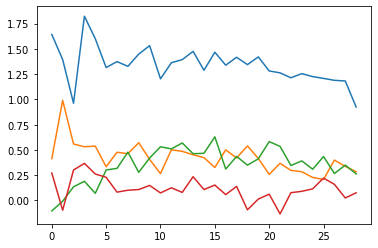

In [70]:
for i in [0, 3, 5, 50]:
    plt.plot(pow_uM_per_s[i]);

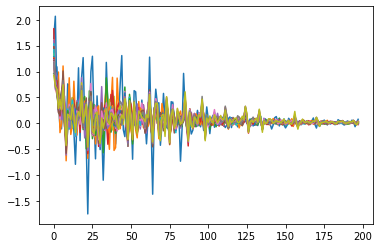

In [77]:
plt.plot(pow_uM_per_s)

/tmp/ipykernel_230511/2366305080.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


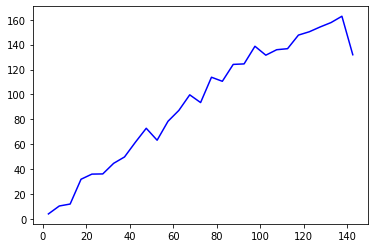

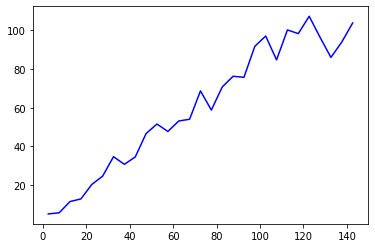

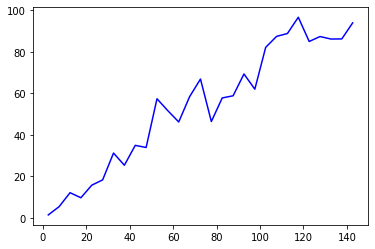

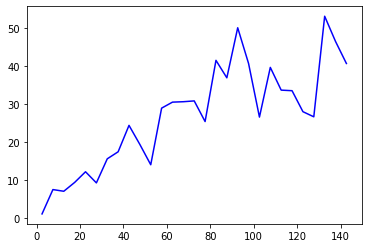

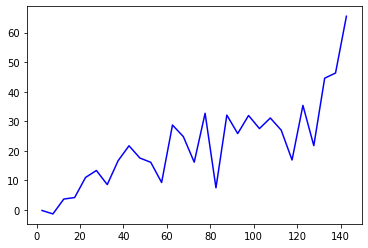

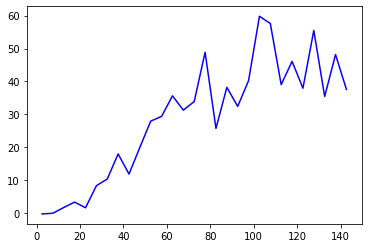

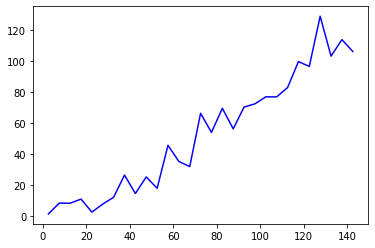

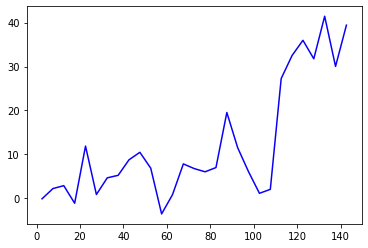

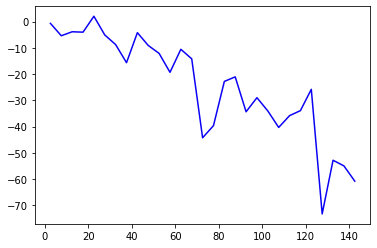

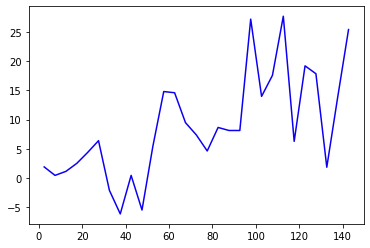

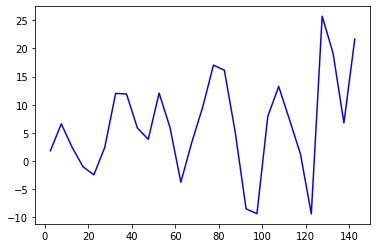

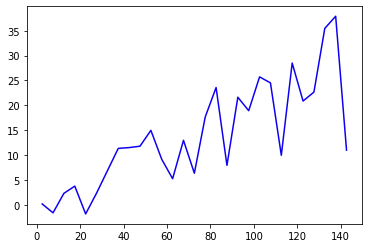

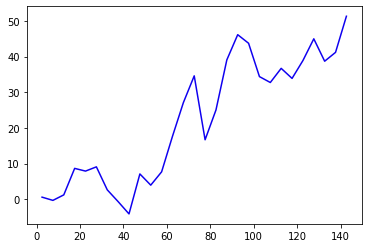

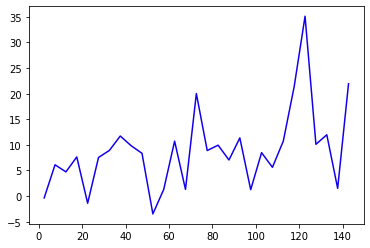

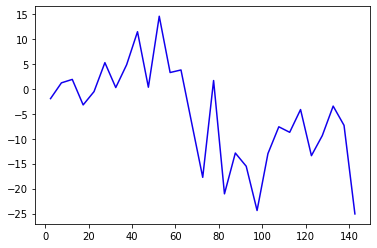

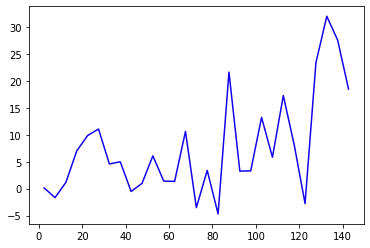

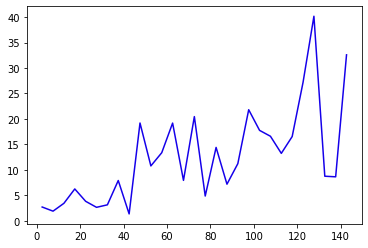

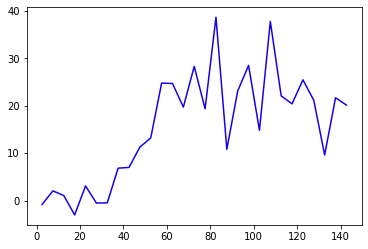

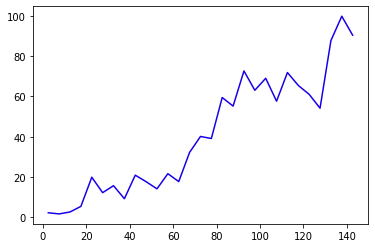

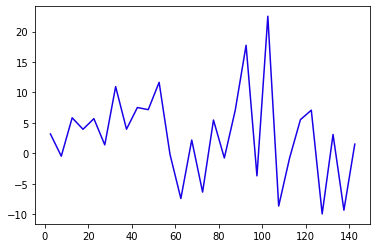

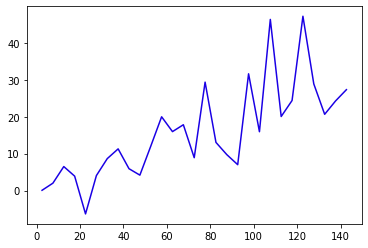

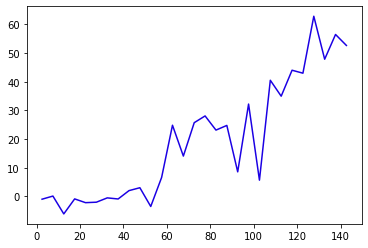

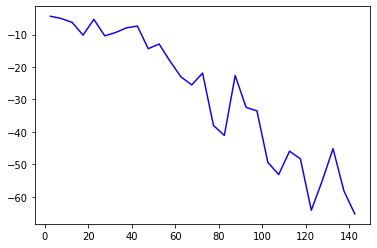

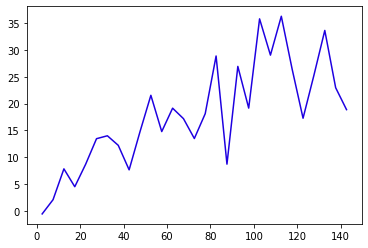

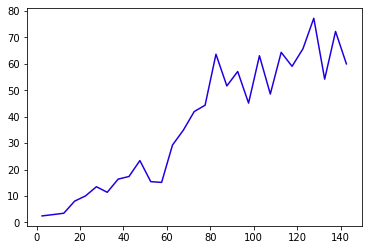

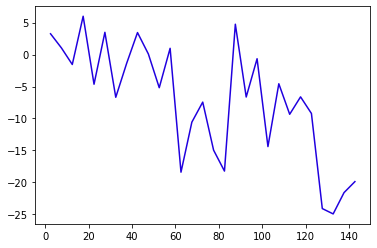

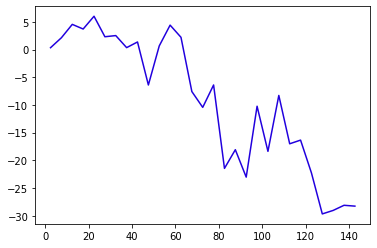

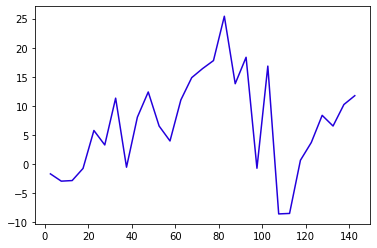

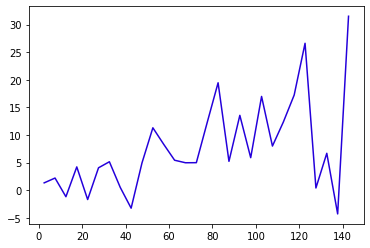

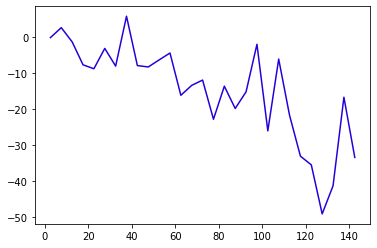

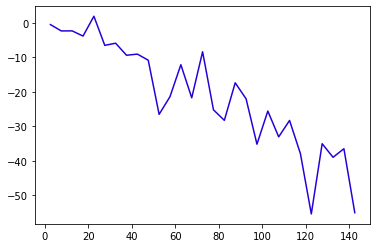

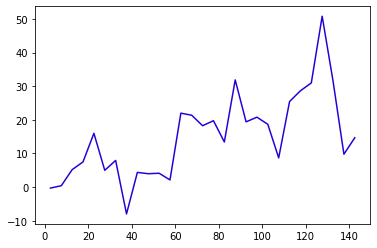

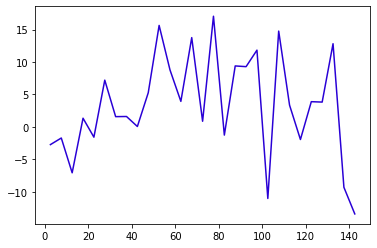

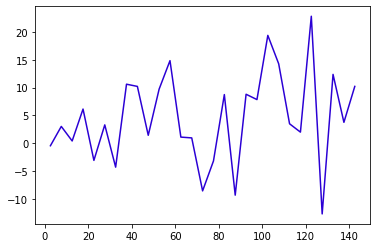

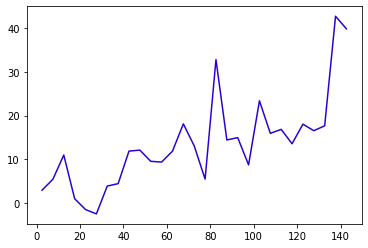

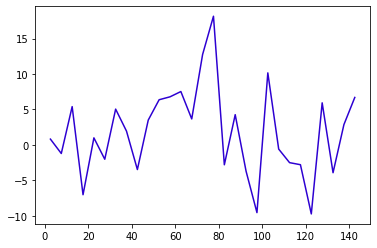

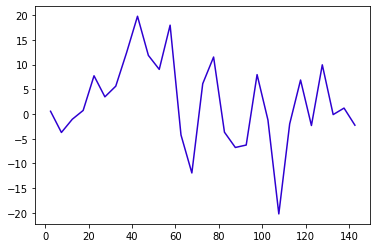

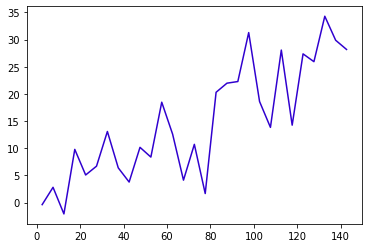

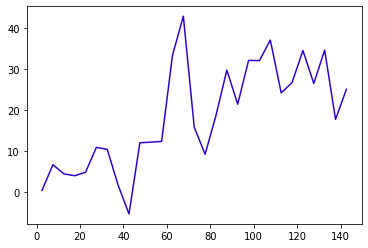

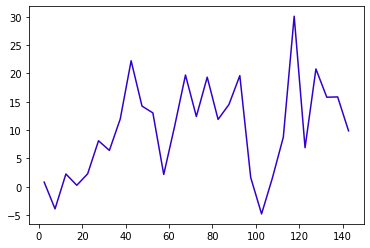

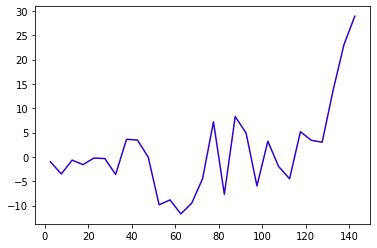

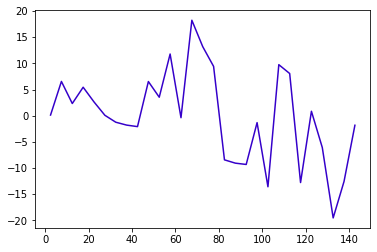

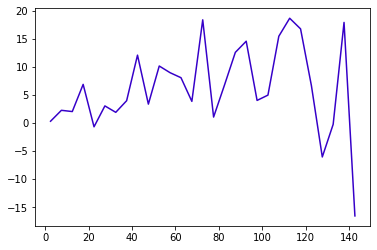

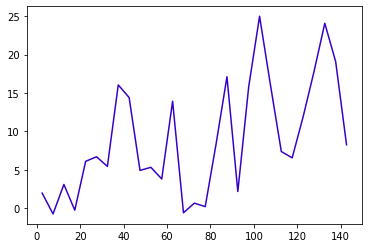

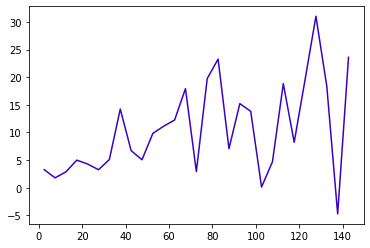

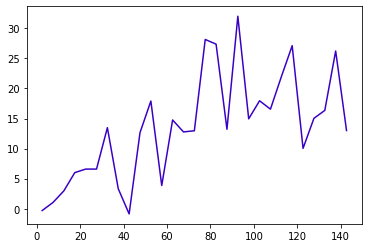

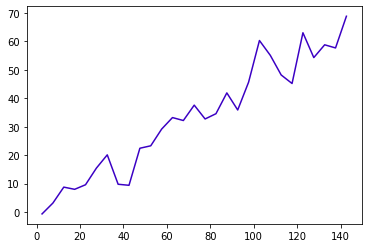

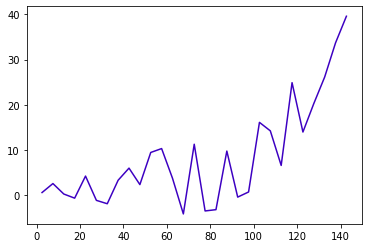

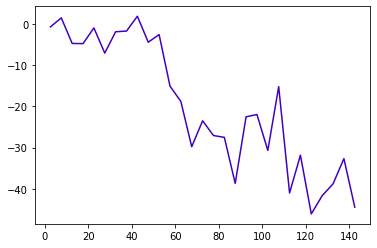

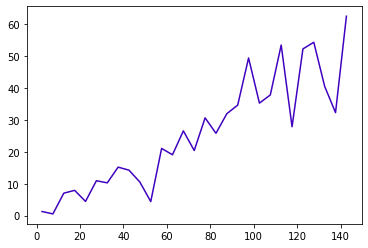

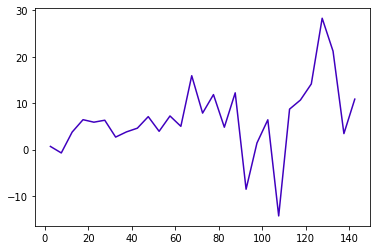

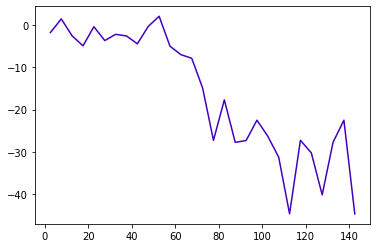

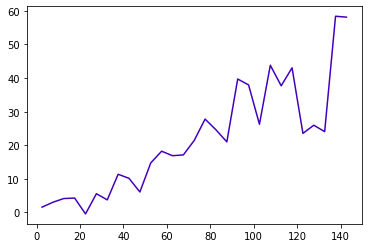

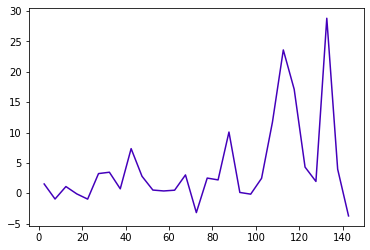

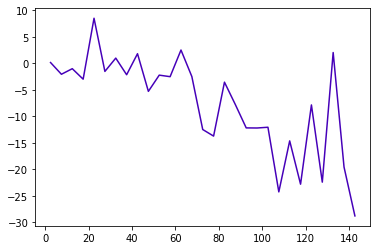

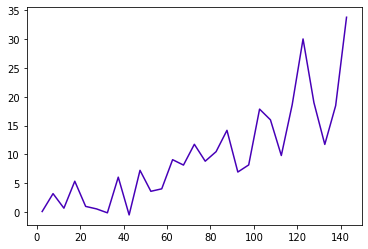

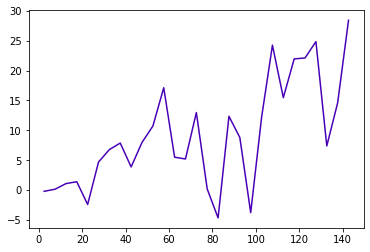

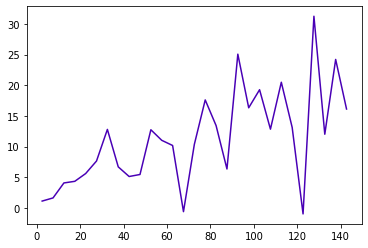

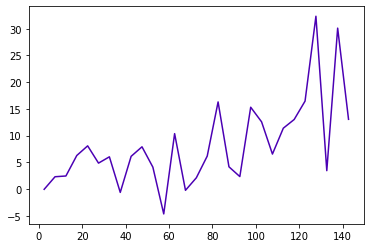

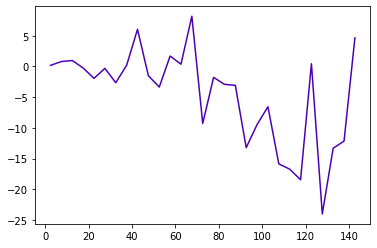

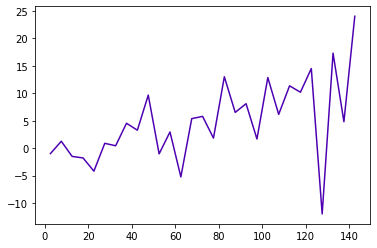

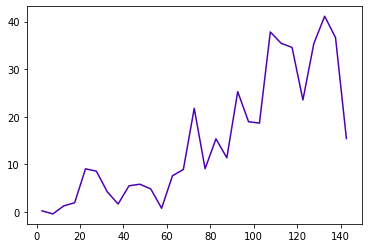

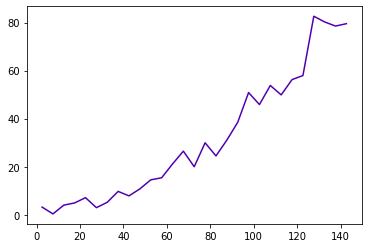

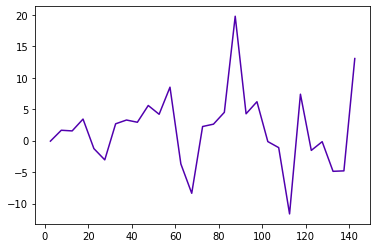

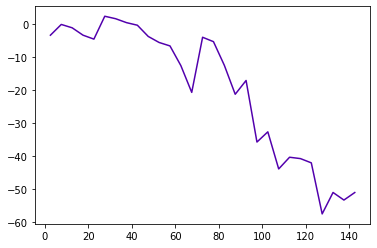

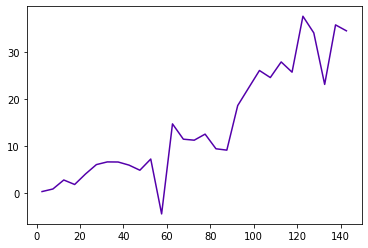

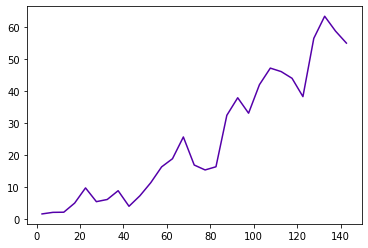

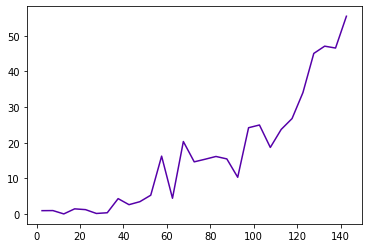

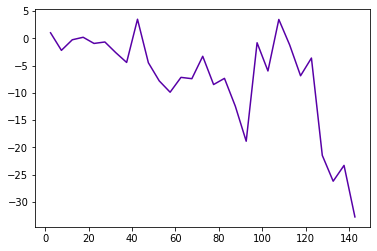

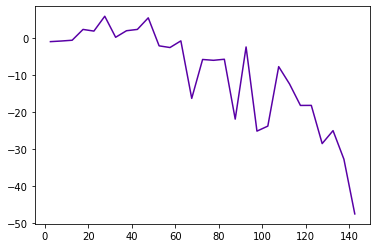

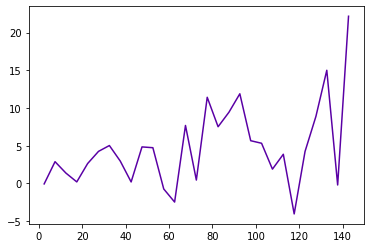

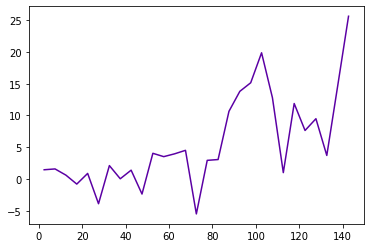

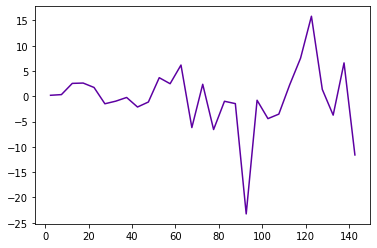

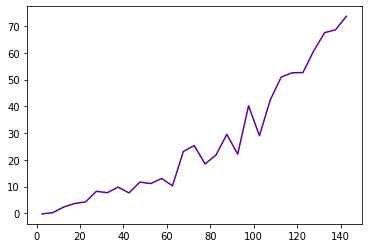

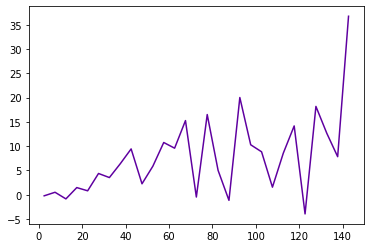

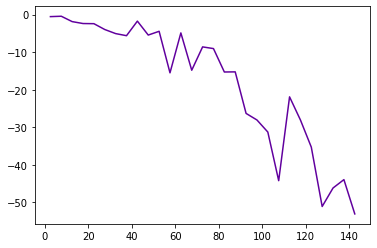

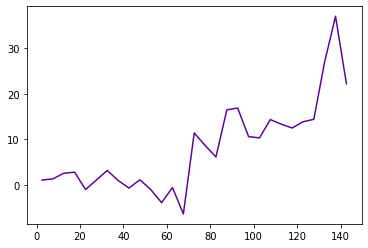

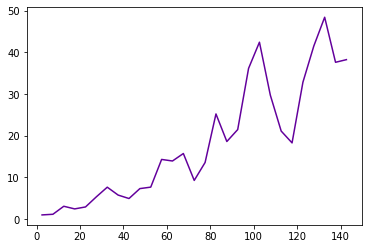

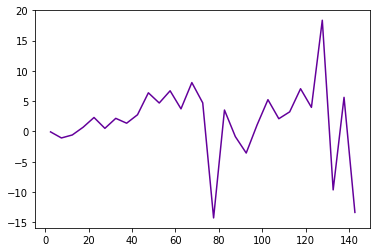

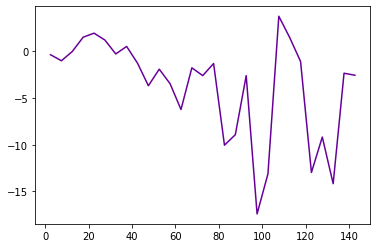

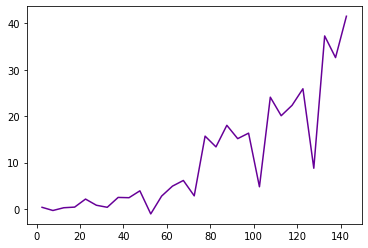

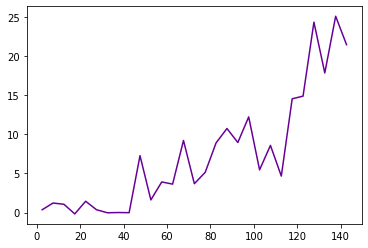

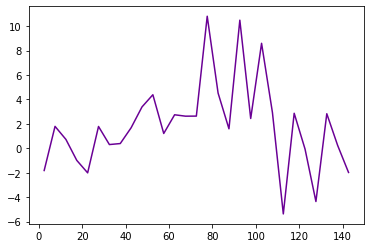

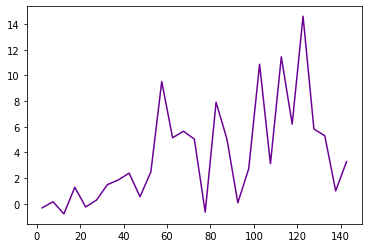

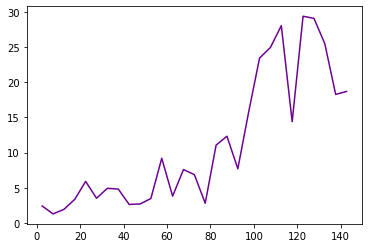

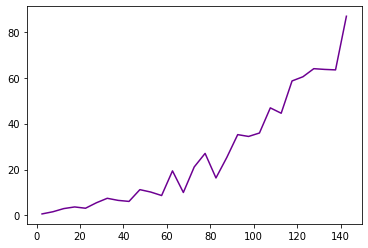

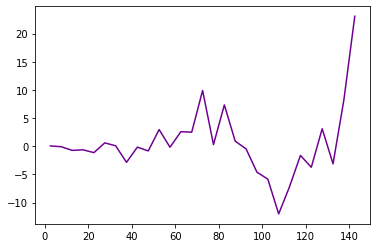

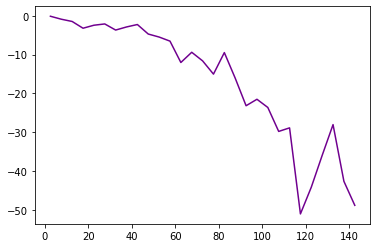

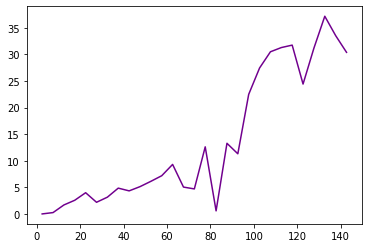

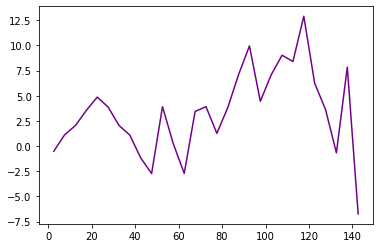

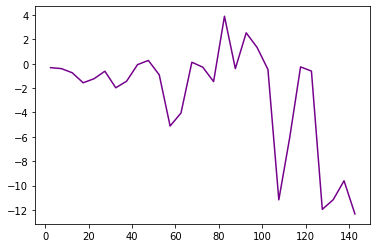

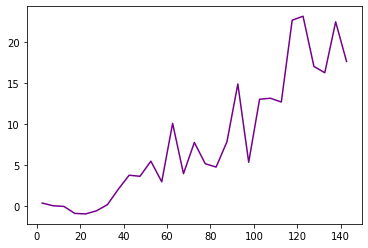

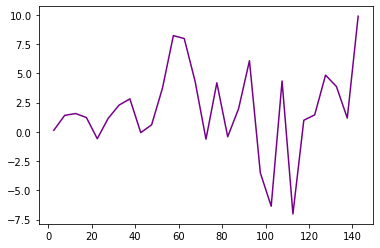

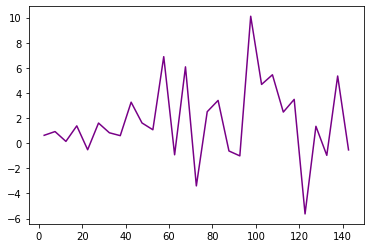

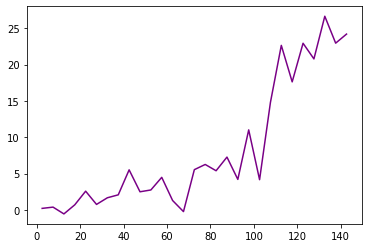

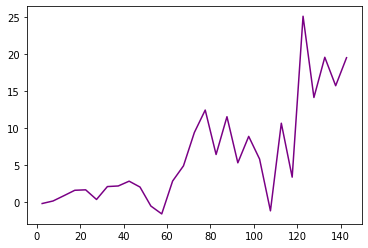

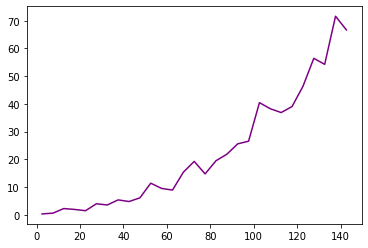

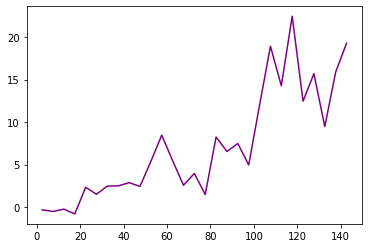

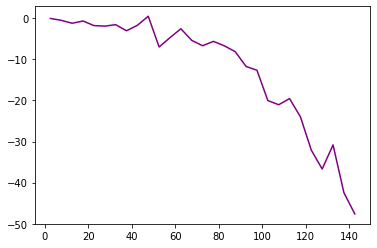

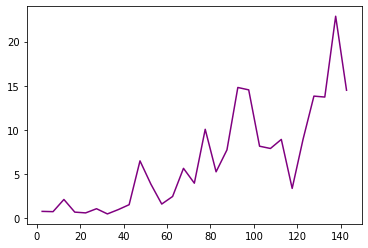

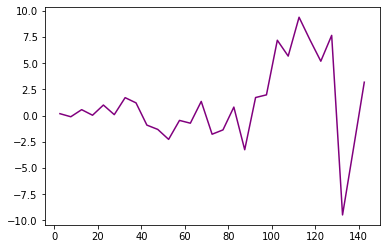

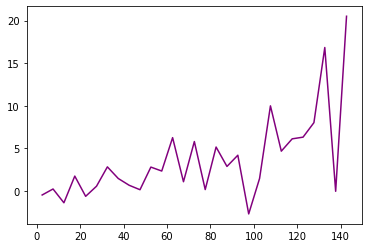

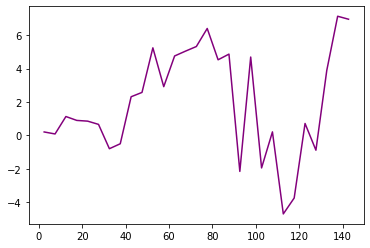

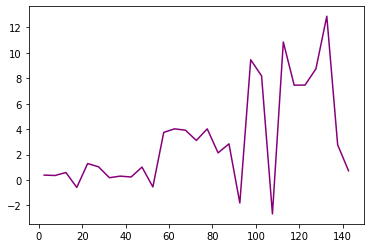

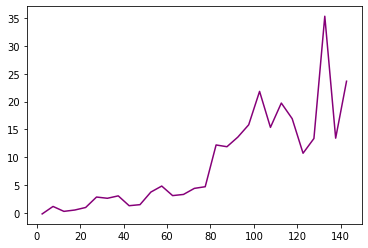

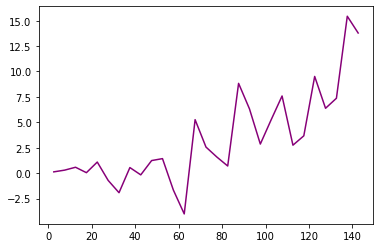

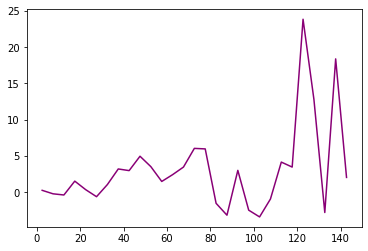

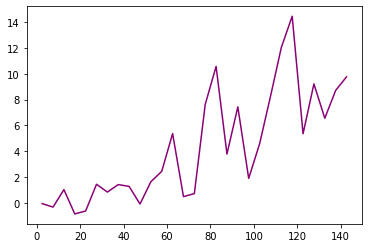

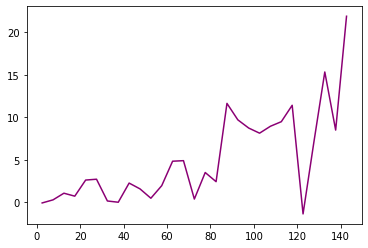

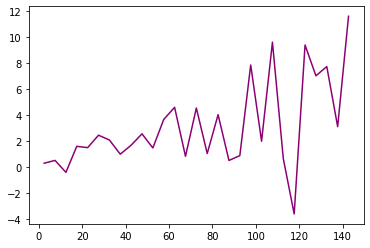

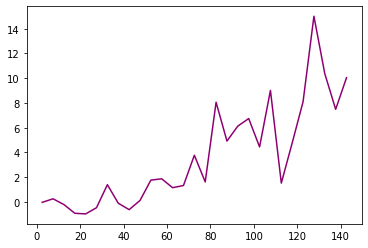

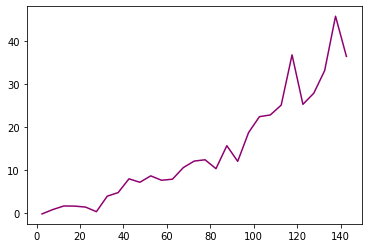

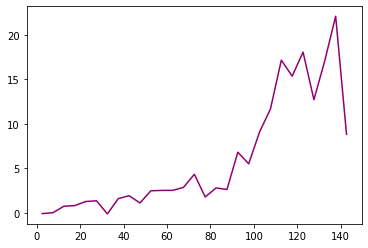

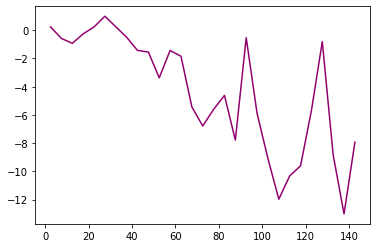

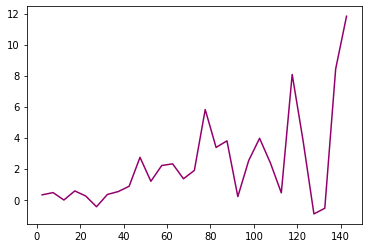

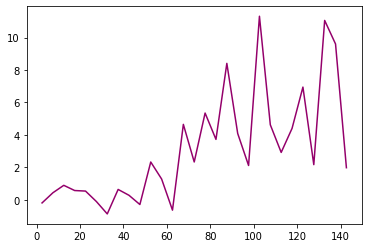

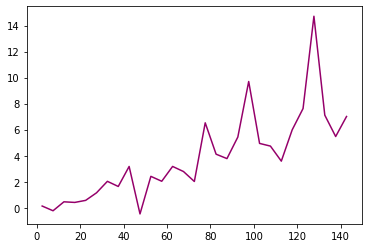

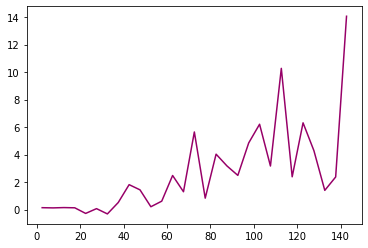

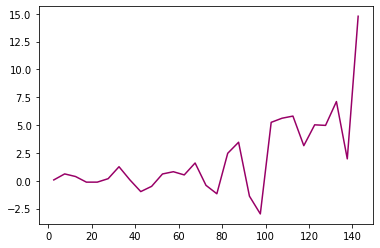

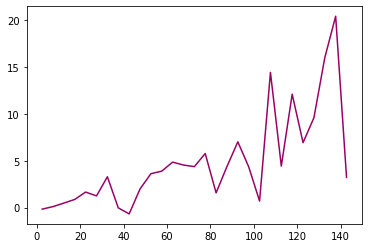

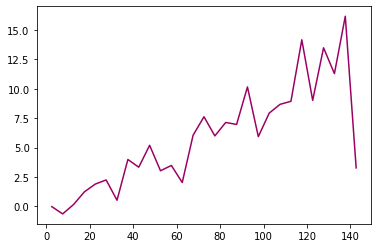

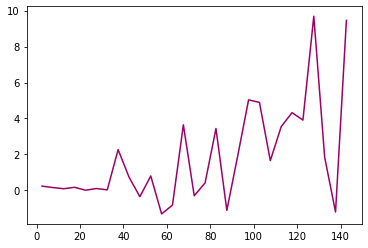

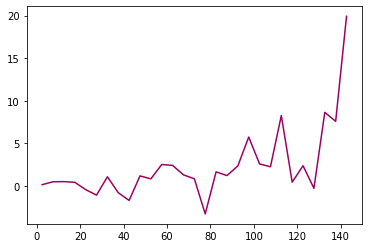

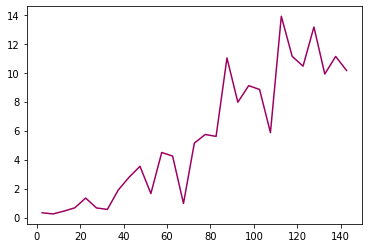

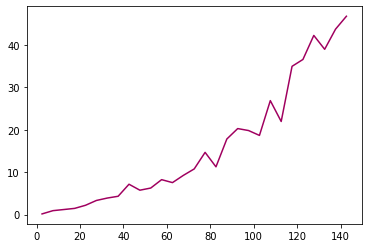

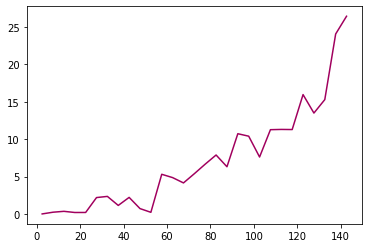

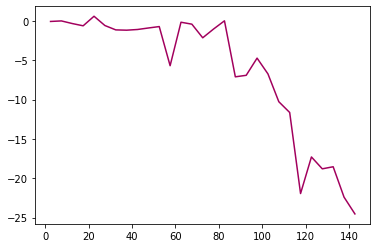

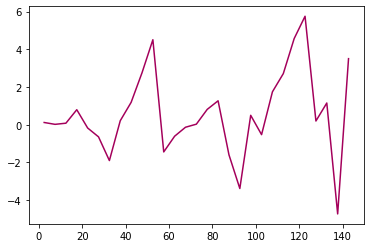

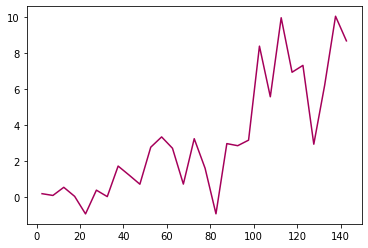

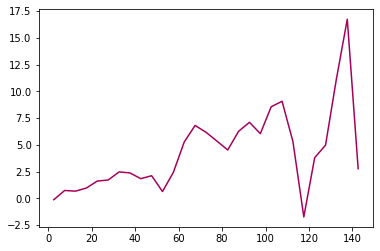

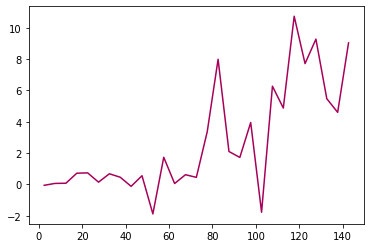

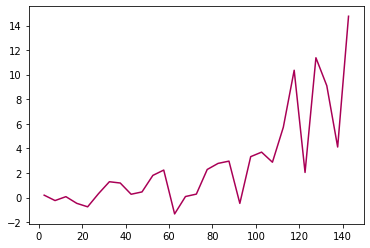

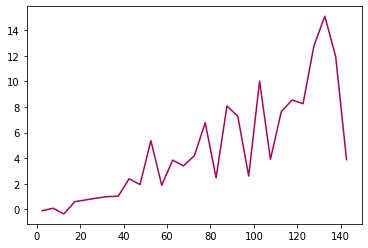

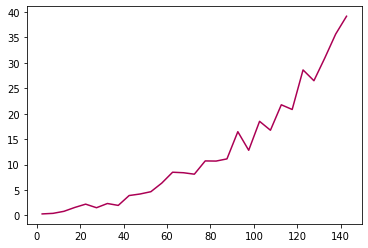

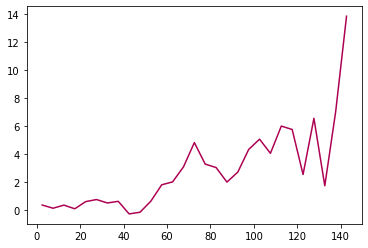

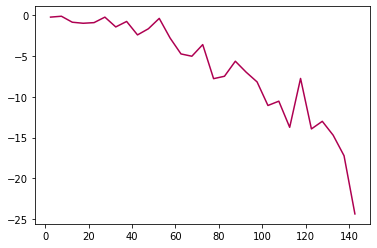

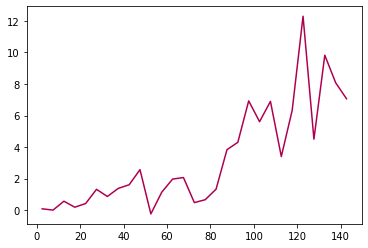

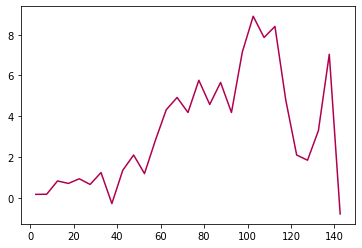

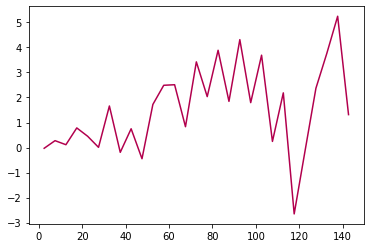

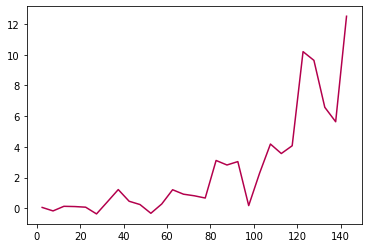

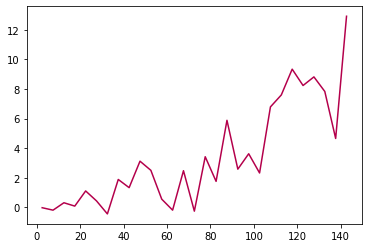

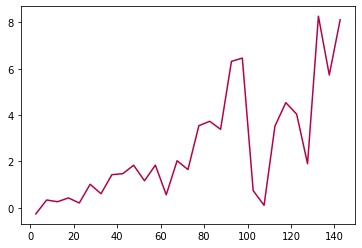

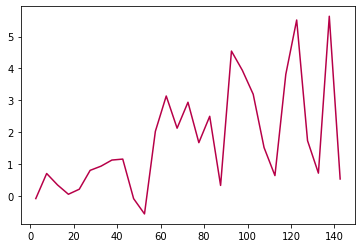

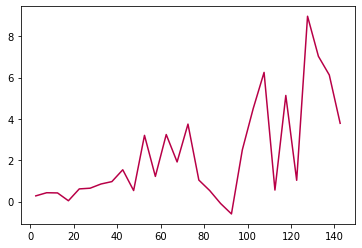

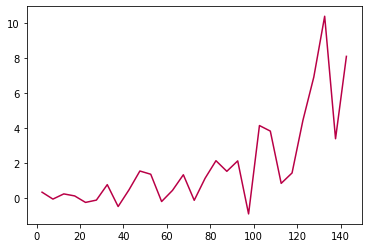

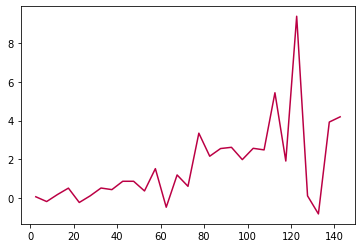

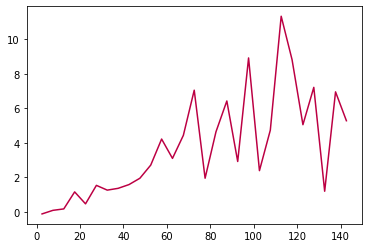

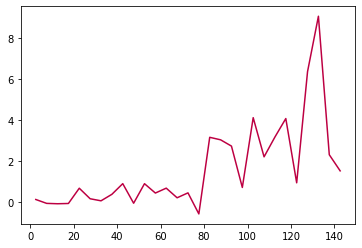

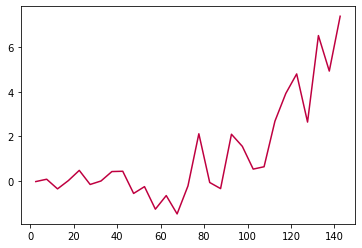

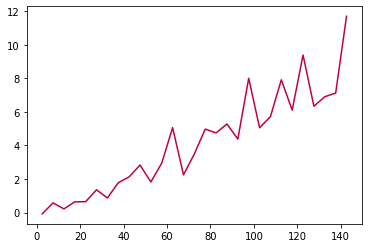

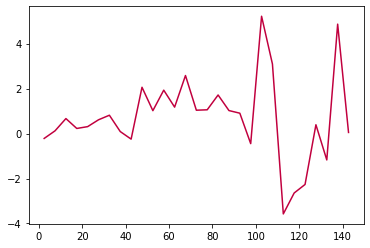

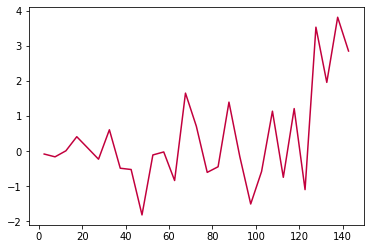

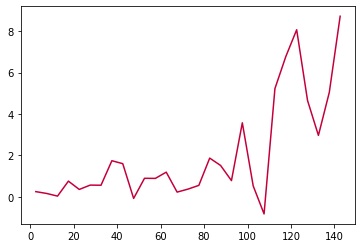

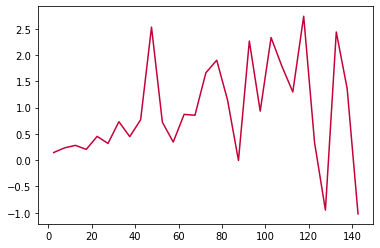

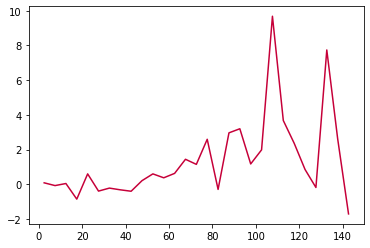

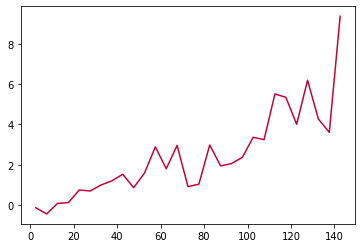

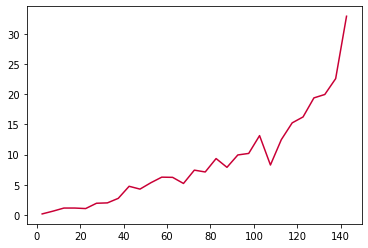

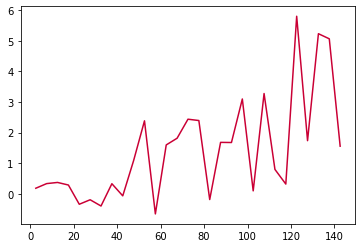

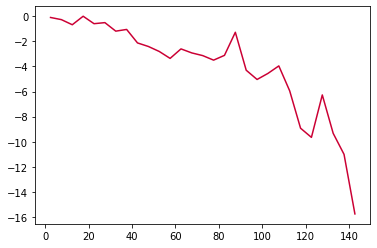

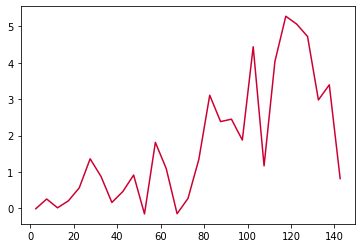

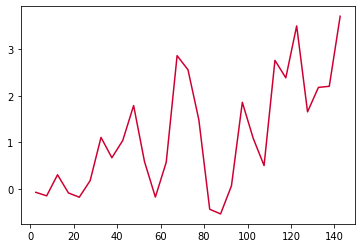

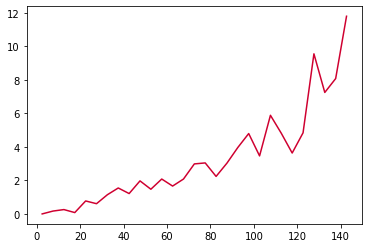

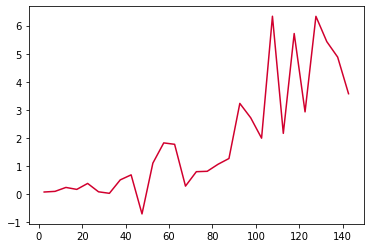

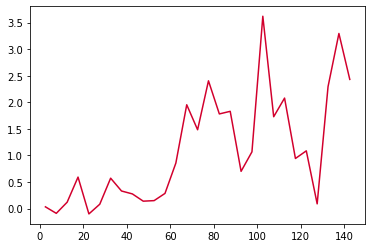

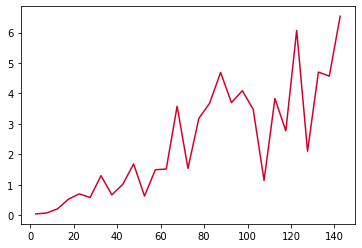

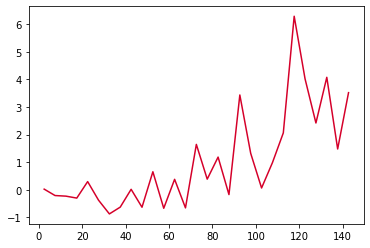

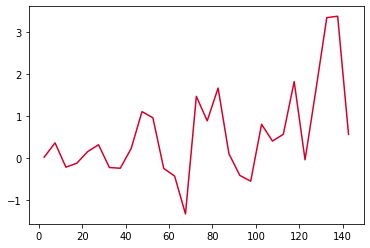

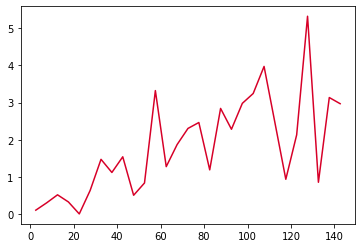

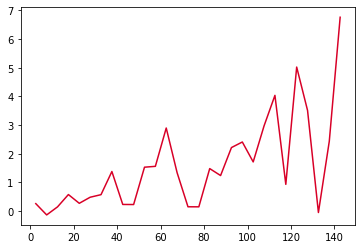

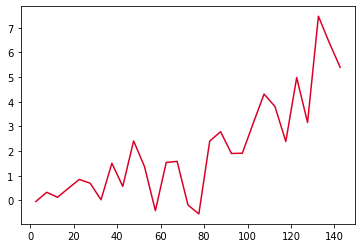

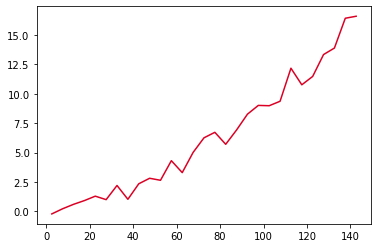

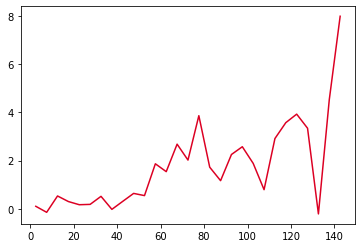

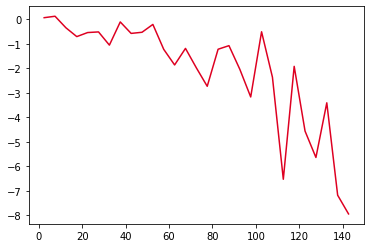

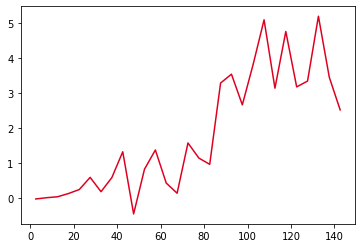

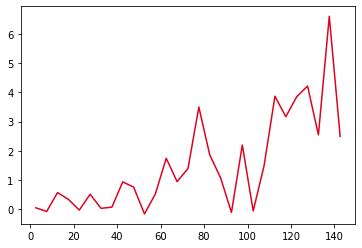

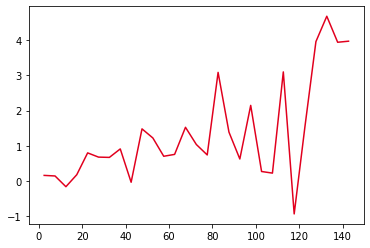

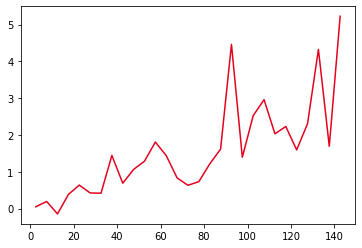

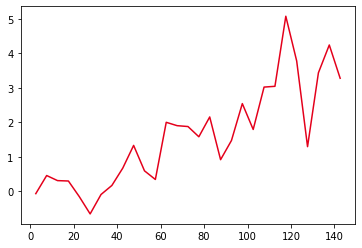

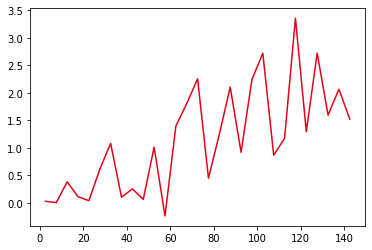

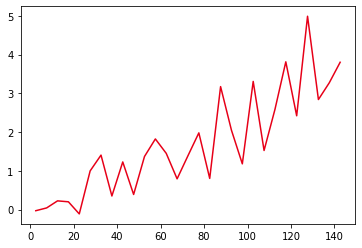

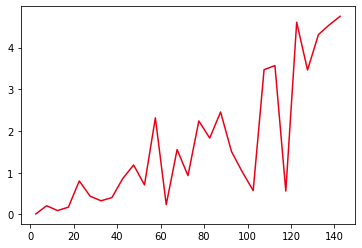

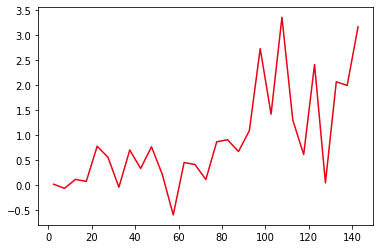

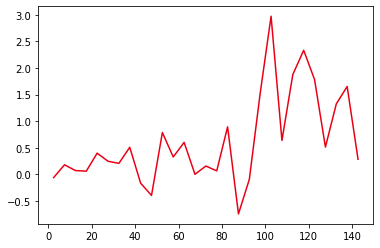

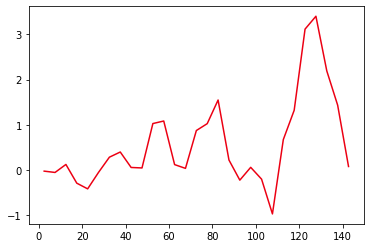

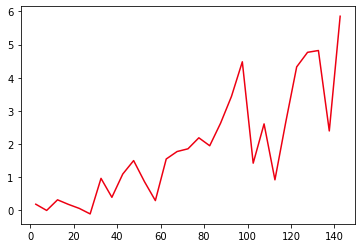

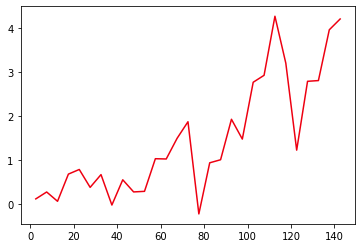

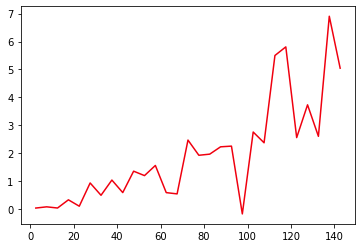

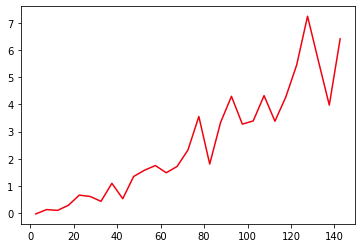

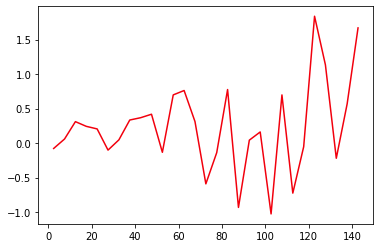

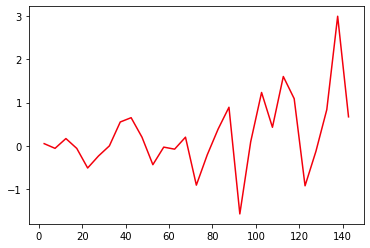

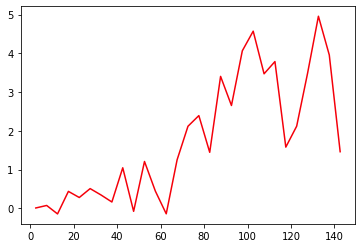

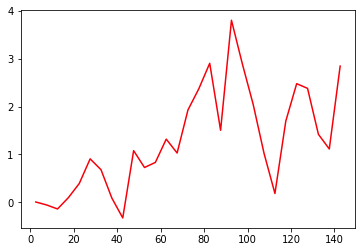

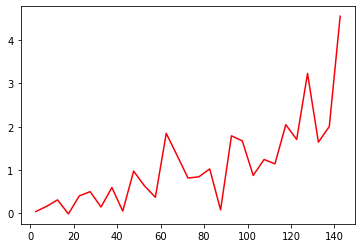

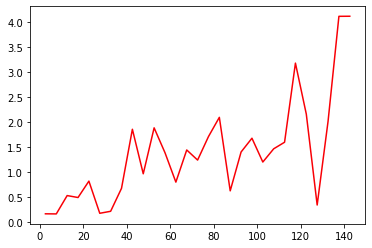

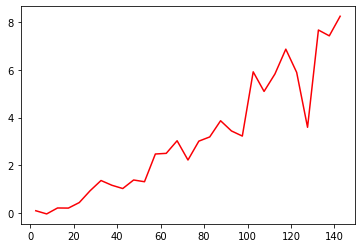

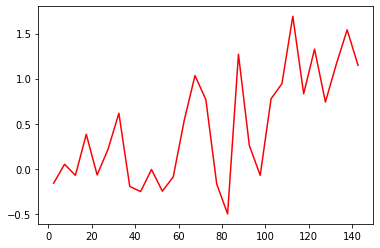

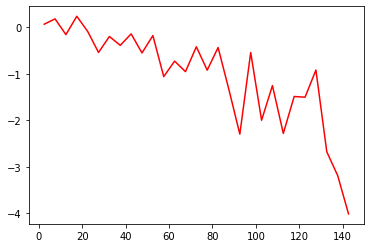

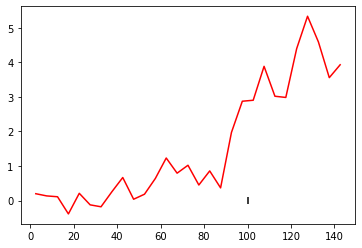

In [89]:
blah = np.arange(198)#[110, 130, 150, 170, 190]
for i, bla in enumerate(blah):
    fig,ax = plt.subplots()
    ax.plot(h5dic['all_rATPbins'][0]*6*0.59,pow_uM_per_s[bla]*h5dic['all_rATPbins'][0]*6*0.59, color = (i/len(blah), 0, 1-i/len(blah)));
plt.vlines(100, -0.1, 0.1, color='k')

In [68]:
pow_uM_per_s.shape

(198, 29)

In [103]:
ATP_shell_vol_L=shell_size(h5dic['all_rATPbins'][0]*6)#NEED TO FIX: when downsampled didnt correct for reduction in # pixels --> need to multiply rbins by downsample factor
powerShells, timesPower = powerShells(h5dic['all_rATPavgs'], h5dic['timesATP'], ATP_shell_vol_L)
ATPShells = shellScale(h5dic['all_rATPavgs'], ATP_shell_vol_L) 
Mot_shell_vol_L=shell_size(h5dic['all_rMotbins'][0])
MotShells = shellScale(h5dic['all_rMotavgs'], Mot_shell_vol_L)

In [42]:
h5dic['all_rATPavgs'].shape

KeyError: 'all_rATPavgs'

In [59]:
np.diff(h5dic['all_rATPavgs'], axis=0).shape

(159, 29)

In [63]:
h5dic['all_rATPbins'].shape

(160, 29)

In [70]:
shell_size(h5dic['all_rATPbins'][0])

array([7.65511882e-14, 2.29653565e-13, 3.82755941e-13, 5.35858317e-13,
       6.88960694e-13, 8.42063070e-13, 9.95165446e-13, 1.14826782e-12,
       1.30137020e-12, 1.45447258e-12, 1.60757495e-12, 1.76067733e-12,
       1.91377970e-12, 2.06688208e-12, 2.21998446e-12, 2.37308683e-12,
       2.52618921e-12, 2.67929159e-12, 2.83239396e-12, 2.98549634e-12,
       3.13859872e-12, 3.29170109e-12, 3.44480347e-12, 3.59790584e-12,
       3.75100822e-12, 3.90411060e-12, 4.05721297e-12, 4.21031535e-12,
       4.36341773e-12])

In [71]:
h5dic['all_rATPavgs'].shape

(160, 29)

In [75]:
np.array([[1,2,3], [1,2,3]]) *np.array([3,4, 5])

array([[ 3,  8, 15],
       [ 3,  8, 15]])

In [79]:
h5dic['timesATP'], h5dic['timesATP'][:-1])/2

(array([  10.,   30.,   50.,   70.,   90.,  110.,  130.,  150.,  170.,
         190.,  210.,  230.,  250.,  270.,  290.,  310.,  330.,  350.,
         370.,  390.,  410.,  430.,  450.,  470.,  490.,  510.,  530.,
         550.,  570.,  590.,  610.,  630.,  650.,  670.,  690.,  710.,
         730.,  750.,  770.,  790.,  810.,  830.,  850.,  870.,  890.,
         910.,  930.,  950.,  970.,  990., 1010., 1030., 1050., 1070.,
        1090., 1110., 1130., 1150., 1170., 1190., 1210., 1230., 1250.,
        1270., 1290., 1310., 1330., 1350., 1370., 1390., 1410., 1430.,
        1450., 1470., 1490., 1510., 1530., 1550., 1570., 1590., 1610.,
        1630., 1650., 1670., 1690., 1710., 1730., 1750., 1770., 1790.,
        1810., 1830., 1850., 1870., 1890., 1910., 1930., 1950., 1970.,
        1990., 2010., 2030., 2050., 2070., 2090., 2110., 2130., 2150.,
        2170., 2190., 2210., 2230., 2250., 2270., 2290., 2310., 2330.,
        2350., 2370., 2390., 2410., 2430., 2450., 2470., 2490., 2510.,
      

In [101]:
h5dic['all_rMotbins'][0], h5dic['all_rATPbins'][0]*6

(array([  3.03448276,   9.10344828,  15.17241379,  21.24137931,
         27.31034483,  33.37931034,  39.44827586,  45.51724138,
         51.5862069 ,  57.65517241,  63.72413793,  69.79310345,
         75.86206897,  81.93103448,  88.        ,  94.06896552,
        100.13793103, 106.20689655, 112.27586207, 118.34482759,
        124.4137931 , 130.48275862, 136.55172414, 142.62068966,
        148.68965517, 154.75862069, 160.82758621, 166.89655172,
        172.96551724]),
 array([  3.,   9.,  15.,  21.,  27.,  33.,  39.,  45.,  51.,  57.,  63.,
         69.,  75.,  81.,  87.,  93.,  99., 105., 111., 117., 123., 129.,
        135., 141., 147., 153., 159., 165., 171.]))

In [104]:
Mot_shell_vol_L, ATP_shell_vol_L

(array([2.81955958e-12, 8.45867873e-12, 1.40977979e-11, 1.97369170e-11,
        2.53760362e-11, 3.10151554e-11, 3.66542745e-11, 4.22933937e-11,
        4.79325128e-11, 5.35716320e-11, 5.92107511e-11, 6.48498703e-11,
        7.04889895e-11, 7.61281086e-11, 8.17672278e-11, 8.74063469e-11,
        9.30454661e-11, 9.86845852e-11, 1.04323704e-10, 1.09962824e-10,
        1.15601943e-10, 1.21241062e-10, 1.26880181e-10, 1.32519300e-10,
        1.38158419e-10, 1.43797538e-10, 1.49436658e-10, 1.55075777e-10,
        1.60714896e-10]),
 array([2.75584277e-12, 8.26752832e-12, 1.37792139e-11, 1.92908994e-11,
        2.48025850e-11, 3.03142705e-11, 3.58259561e-11, 4.13376416e-11,
        4.68493272e-11, 5.23610127e-11, 5.78726983e-11, 6.33843838e-11,
        6.88960694e-11, 7.44077549e-11, 7.99194405e-11, 8.54311260e-11,
        9.09428116e-11, 9.64544971e-11, 1.01966183e-10, 1.07477868e-10,
        1.12989554e-10, 1.18501239e-10, 1.24012925e-10, 1.29524610e-10,
        1.35036296e-10, 1.40547982e-10

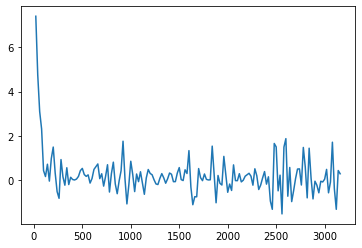

In [107]:
plt.plot(timesPower[:-1], np.sum(power, axis=1)[:-1]/np.sum(MotShells, axis=1)[:-3])

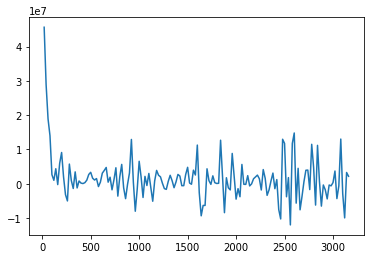

In [90]:
plt.plot(timesPower[:-1], np.sum(power, axis=1)[:-1])

## Might as well do for prc1 experiments now too...


In [ ]:
## main differences: 
# raw data are in /home/aduarte/am_atp/data/aster/prc1expts
# metadata file is 
metaDataFile_prc1='../../data/aster/prc1expts/20241116_footageComments_gnames_PRC1.csv'